# Chapter 11-5. RNN seq2seq


https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

- Seq2Seq
- Apply Seq2Seq
    - Encoder - Decoder
    - Data Preprocessing
    - Neural Net Setting
    - Training
    - Evaluation

---

## Seq2Seq

- 시퀀스를 입력받고, 시퀀스를 출력하는 모델
- 이미 RNN이 시퀀셜 데이터를 다루기 위해 만들어졌다고 함
    - S2S와 일반 RNN의 차이점?

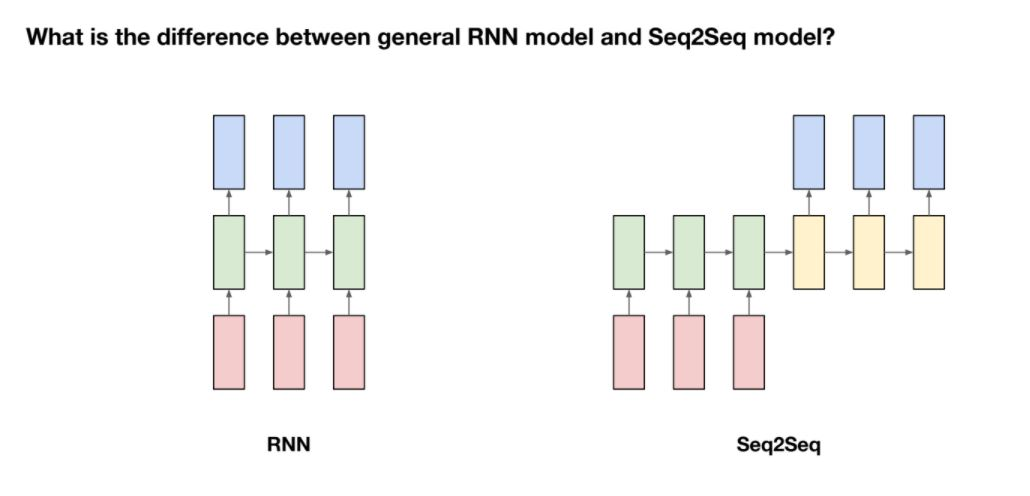

### Ex: ChatBot
- 번역, 챗봇에서 유용하게 쓰임

- RNN 모델: 문장 구성 모델(단어) 입력 → 그때마다 출력 내놓아서 답변 만듦
    - "한국말은 끝까지 들어 봐야 안다."
    - 문장을 듣기도 전에 답변을 만들면, 끝에서의 변화들 때문에 제대로 된 답변을 내놓기 어려움
    
- Seq2Seq:*끝까지 듣고 말하기*

---

## Apply Seq2Seq

### *Encoder-Decoder*
S2S 모델의 대표적인 특징

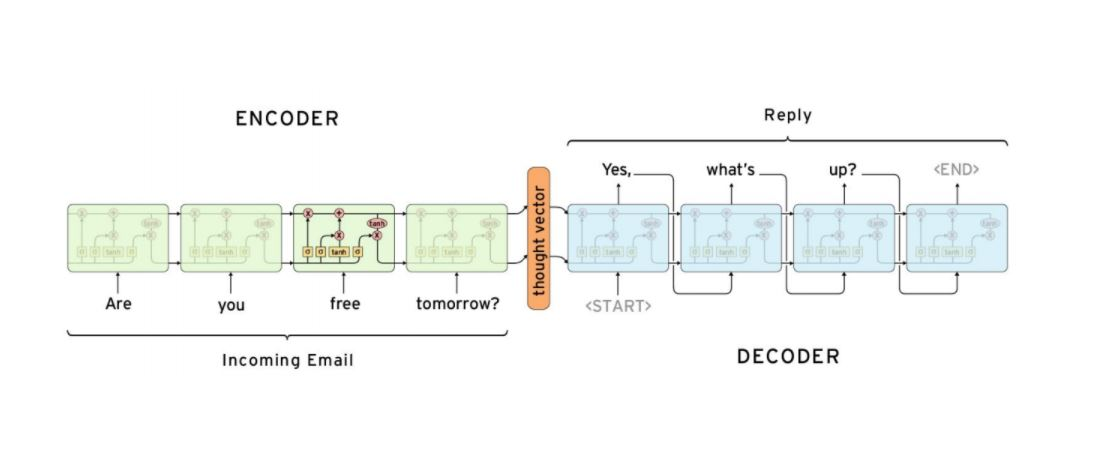

- Encoder: 입력된 단어들의 시퀀스(문장)을 벡터의 형태로 압축

    - 압축된 벡터를 Decoder로 전달
    
    
- Decoder: Encoder으로부터 전달받은 vector을 첫 셀의 hidden state로 넣어 주고, 이 문장이 시작한다는 start flag와 함께 모델 시작

    - 셀에서 나온 output을 이 문장에 만들어진 답변의 첫 번째 단어로 둠
    - 이 단어가 다시 두 번째 셀에 입력이 들어감
    - 이 전 셀의 hidden state와 함께 다음 단어 예측
    - 계속 예측이 진행됨
    - decoder에서는 하나의 문장을 만들어낼 수 있음
        - *encoder에서 모든 문장을 들은 후에!*
        
        
- RNN 2개 연결하여 만들면 됨

### 구조

맨 앞과 맨 뒤만 발췌

```python
import random
import torch
import torch.nn as nn
from torch import optim

# 약 180줄 존재

SOURCE_MAX_LENGTH = 10
TARGET_MAX_LENGTH = 12
load_pairs, load_source_vocab, load_target_vocab = preprocess(raw, SOURCE_MAX_LENGTH, TARGET_MAX_LENGTH) # preprocess 보조 함수 정의
print(random.choice(load_pairs))

enc_hidden_size = 16 # 인코더의 히든 스테이트 정의
dec_hidden_size = enc_hidden_size # 디코더의 히든 스테이트도 인코더의 히든 스테이트와 같은 크기로 정의
enc = Encoder(load_source_vocab.n_vocab, enc_hidden_size).to(device)
dec = Decoder(dec_hidden_size, load_target_vocab.n_vocab).to(device)
# 인코더와 디코더라는 클래스를 선언
# 두 RNN 모델
# 굉장히 단순한 모델로 되어 있음 -> 성능의 한계 있음
# 두 클래스를 이용하여 학습 진행

train(load_pairs, load_source_vocab, load_target_vocab, enc, dec, 5000, print_every=1000)
# train이라는 보조 함수에 encoder의 출력을 decoder로 연결해 주는 부분이 있을 것
# encoder part 쭉 진행, 그 출력물을 decoder에 넣어 주는 부분이 train 안에 있을 것

evaluate(load_pairs, load_source_vocab, load_target_vocab, enc, dec, TARGET_MAX_LENGTH)
# 전체 모델 학습이 끝나면 남겨 둔 test set을 가지고 evaluate
```

- 마지막 10줄: 전체 200줄에서 진행되는 내용 압축하고 있는 코드

    - 번역 테스트 수행하는 S2S 모델 구현한 코드
    
    - 번역: 원본 소스 텍스트 -> 타겟 텍스트로 바꾸어야 되는 상황
        - 소스 텍스트(S) 여기에서는 영어 문장
        - 타겟 틱스트(T) 이 문장을 번역한 한국어 문장
        - 영어 -> 한국어 잘 번역하면 잘 된 문장
        
    - S, T 각각 training set과 test set으로 나누어서 train set으로 학습시킨 후 test set으로 검증
        - **preprocess**라는 보조 함수: 각각의 train set이 몇 개의 단어로 되어 있는지, 그건 뭔지 그런 것들을 찾아내는 과정을, 나누는 과정까지를 진행
        - 이때 소스 텍스트를 구성하는 최대 길이를 제한하고 타겟 문장의 최대 길이도 제한해 줌
        - 학습의 대상이 되는 함수들을 나누어 주게 됨
        
    

### Data Preprocessing

In [1]:
import random
import torch
import torch.nn as nn
from torch import optim

In [2]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 데이터 선언
- 예제: 4개 정도만 간단하게 4개 정도와, tab으로 구분된 한국어 문장 넣음

In [3]:
raw = ["I feel hungry.	나는 배가 고프다.",
       "Pytorch is very easy.	파이토치는 매우 쉽다.",
       "Pytorch is a framework for deep learning.	파이토치는 딥러닝을 위한 프레임워크이다.",
       "Pytorch is very clear to use.	파이토치는 사용하기 매우 직관적이다."]

#### SOS, EOS 토큰 (중요)

- SOS: start of sentence
- EOS: end of sentence

- SOS: decoder가 히든 스테이트로, 인코더의 마지막 출력물을 받아 오고 첫 번째 스탭의 input을 받아야 함. 그 input으로 SOS_token 받게 됨
- EOS: n개 이렇게 쭉 문장 최대 길이 제한. 만약 n개보다 작은 단어들이 사용되고 있음 -> 문장이 끝나게 되면 문장이 끝났다는 뜻에서 EOS라는 토큰을 붙여서 문장의 종류를 알려 줌. 
    - 1번 인덱스를 가진 토큰을 넣음으로서 문장이 끝났다는 것 알려 줌

In [4]:
# fix token for "start of sentence" and "end of sentence"
SOS_token = 0
EOS_token = 1

In [5]:
# class for vocabulary related information of data
class Vocab:
    def __init__(self):
        self.vocab2index = {"<SOS>": SOS_token, "<EOS>": EOS_token}
        self.index2vocab = {SOS_token: "<SOS>", EOS_token: "<EOS>"}
        self.vocab_count = {}
        self.n_vocab = len(self.vocab2index)

    def add_vocab(self, sentence):
        for word in sentence.split(" "):
            if word not in self.vocab2index:
                self.vocab2index[word] = self.n_vocab
                self.vocab_count[word] = 1
                self.index2vocab[self.n_vocab] = word
                self.n_vocab += 1
            else:
                self.vocab_count[word] += 1

In [6]:
# filter out the long sentence from source and target data
def filter_pair(pair, source_max_length, target_max_length):
    return len(pair[0].split(" ")) < source_max_length and len(pair[1].split(" ")) < target_max_length

#### Data Preprocessing
모델의 학습과 직접적인 영향은 없지만 모델이 잘 학습할 수 있도록 데이터를 준비하는 과

- S와 T를 나누어서 어떤 단어로 구성이 되어 있고, 단어 수는 몇 개이고를 측정하는 부분
- \t을 나누어서 진행 ```.split("\t")```
- Vocab class 선언하여 단어의 개수나, 딕셔너리 만들어서 넣어 주게 됨


In [7]:
# read and preprocess the corpus data
def preprocess(corpus, source_max_length, target_max_length):
    print("reading corpus...")
    pairs = []
    for line in corpus:
        pairs.append([s for s in line.strip().lower().split("\t")])
    print("Read {} sentence pairs".format(len(pairs)))

    pairs = [pair for pair in pairs if filter_pair(pair, source_max_length, target_max_length)]
    print("Trimmed to {} sentence pairs".format(len(pairs)))

    source_vocab = Vocab()
    target_vocab = Vocab()

    print("Counting words...")
    for pair in pairs:
        source_vocab.add_vocab(pair[0])
        target_vocab.add_vocab(pair[1])
    print("source vocab size =", source_vocab.n_vocab)
    print("target vocab size =", target_vocab.n_vocab)

    return pairs, source_vocab, target_vocab

#### Neural Net Setting
본격적으로 encoder, deconder 보기

- Encoder: 간단하게 표현
    - forward 부분: 어떻게 진행되는지 알 수 있음
        - x가 embedding 함수를 통과하여 나오게 되고, 이 x가 다시 gru라는 RNN unit을 통과하여 나온 결과를 return 받게 됨.
        
        
- **Embedding**
    - input을 가지고 hidden size만큼의 vector로 줄이는 matrix를 embedding이라고 함
    - [EMB] X [one-hot-encodding vector] -> GRU로 들어가게 됨

In [8]:
# declare simple encoder
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        # embedding layer - 거대한 행렬
        # input_size에는 S text가 들어감.
        # S text를 이루고 있는 말뭉치에서 사용되고 있는 단어의 갯수
        # 100개의 단어가 쓰이고 있다 -> 100개의 창을 가지는 one-hot encoding으로 표현 가능
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        x, hidden = self.gru(x, hidden)
        # gru는 nn.GRU를 이용하여 선언됨
        # pytorch에서 쓰는 방법 굉장히 간단
        ## nn.GRU 하고 dim만 선언해 주면 됨(input과 hidden state(output)의 것만)
        return x, hidden

Decoding도 Encoding과 크게 차이 없음

- Forward 함수
    - x가 embbeding -> gru -> out -> softmax 통과
    - **Out**
        - Linear matrix
        - matrix 연산: 왜? GRU에서 일어나는 일:
            - input1: hidden state로는 직전 encoder의 최종 output 들어옴
            - input2: one-hot-vector가 들어옴 (+ EMB) -> 우리가 필요한 크기로 줄어든 vector
            - output: hidden dim만큼의 vector 출력
        - 따라서 나온 것을 가지고 다시 *target text에 사용되고 있는 단어로 복원하는 레이어* 필요
             - out이라는 linear layer가 해 주게 됨

In [9]:
# declare simple decoder
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        x = self.embedding(x).view(1, 1, -1)
        x, hidden = self.gru(x, hidden)
        x = self.softmax(self.out(x[0]))
        return x, hidden

#### Training

- Tensorize 함수
    - sentence 입력 받아서 sentence를 one-hot-encoding으로 바꾸고, one-hot-vector을 pytorch에서 사용하는 tensor로 바꿈
    - *Sentence -> One Hot Vector*

In [10]:
# convert sentence to the index tensor
def tensorize(vocab, sentence):
    indexes = [vocab.vocab2index[word] for word in sentence.split(" ")]
    indexes.append(vocab.vocab2index["<EOS>"])
    return torch.Tensor(indexes).long().to(device).view(-1, 1)

본격적 학습 시작

In [11]:
def train(pairs, source_vocab, target_vocab, encoder, decoder, n_iter, print_every=1000, learning_rate=0.01):
    loss_total = 0

    # optimizer 선언
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # batch -> random하게 필요한 학습 데이터 추출
    # sorce text와 target text로 나누는 작업을 여기에서 하게 됨
    training_batch = [random.choice(pairs) for _ in range(n_iter)]
    training_source = [tensorize(source_vocab, pair[0]) for pair in training_batch]
    training_target = [tensorize(target_vocab, pair[1]) for pair in training_batch]

    # loss를 재는 기준: NLLLoss 함수 이용
    # 최종적으로 decoder에 출력으로 나오는 단어들(벡터들)이 원래의 단어와 얼마나 잘 맞는지
    # 카테고리 value들과 비교
    # 이럴 때 많이 사용하는 NLLLoss 함수
    criterion = nn.NLLLoss()

    # inter만큼의 loop를 돌면서 
    # 첫 input: 첫 문장의 첫 단어. embadding을 거쳐서 들어가게 됨
    for i in range(1, n_iter + 1):
        source_tensor = training_source[i - 1]
        target_tensor = training_target[i - 1]

        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)
        # 첫 번째 hidden state는 0 vector을 넣어 줌
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        source_length = source_tensor.size(0)
        target_length = target_tensor.size(0)

        loss = 0

        for enc_input in range(source_length):
            _, encoder_hidden = encoder(source_tensor[enc_input], encoder_hidden)
            # 학습이 끝날 때까지 loop를 돌면서 인코더의 hidden state 꺼내 오게 됨
            
        # 인코더의 마지막 hidden state를 decoder의 첫 hidden으로 넣어 주는 과정
        decoder_input = torch.Tensor([[SOS_token]]).long().to(device)
        # decoder part의 첫 GRU에 들어가는 입력값 - start of tocken(SOS)
        decoder_hidden = encoder_hidden # connect encoder output to decoder input
        
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # teacher forcing
            # GRU의 예측값을 다음 셀에 넣을 수도 있는데, 
            # 넣지 않고 대신 정답을 넣을 수도 있음
            # -> 이렇게 되면 학습이 빠를 수는 있지만 네트워크가 조금 더 불안해짐.
            # --> 전부 다 teacher forcing 하지 않고, 50%의 확률 30% 확률 이렇게 할 수도 있음.

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        loss_iter = loss.item() / target_length
        loss_total += loss_iter

        if i % print_every == 0:
            loss_avg = loss_total / print_every
            loss_total = 0
            print("[{} - {}%] loss = {:05.4f}".format(i, i / n_iter * 100, loss_avg))

In [12]:
# insert given sentence to check the training
def evaluate(pairs, source_vocab, target_vocab, encoder, decoder, target_max_length):
    for pair in pairs:
        print(">", pair[0])
        print("=", pair[1])
        source_tensor = tensorize(source_vocab, pair[0])
        source_length = source_tensor.size()[0]
        encoder_hidden = torch.zeros([1, 1, encoder.hidden_size]).to(device)

        for ei in range(source_length):
            _, encoder_hidden = encoder(source_tensor[ei], encoder_hidden)

        decoder_input = torch.Tensor([[SOS_token]], device=device).long()
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(target_max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, top_index = decoder_output.data.topk(1)
            if top_index.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(target_vocab.index2vocab[top_index.item()])

            decoder_input = top_index.squeeze().detach()

        predict_words = decoded_words
        predict_sentence = " ".join(predict_words)
        print("<", predict_sentence)
        print("")

In [13]:
# declare max length for sentence
SOURCE_MAX_LENGTH = 10
TARGET_MAX_LENGTH = 12

In [14]:
# preprocess the corpus
load_pairs, load_source_vocab, load_target_vocab = preprocess(raw, SOURCE_MAX_LENGTH, TARGET_MAX_LENGTH)
print(random.choice(load_pairs))

reading corpus...
Read 4 sentence pairs
Trimmed to 4 sentence pairs
Counting words...
source vocab size = 17
target vocab size = 13
['pytorch is very clear to use.', '파이토치는 사용하기 매우 직관적이다.']


In [15]:
# declare the encoder and the decoder
enc_hidden_size = 16
dec_hidden_size = enc_hidden_size
enc = Encoder(load_source_vocab.n_vocab, enc_hidden_size).to(device)
dec = Decoder(dec_hidden_size, load_target_vocab.n_vocab).to(device)

In [16]:
# train seq2seq model
train(load_pairs, load_source_vocab, load_target_vocab, enc, dec, 5000, print_every=1000)

[1000 - 20.0%] loss = 0.7333
[2000 - 40.0%] loss = 0.1081
[3000 - 60.0%] loss = 0.0340
[4000 - 80.0%] loss = 0.0184
[5000 - 100.0%] loss = 0.0124


In [17]:
# check the model with given data
evaluate(load_pairs, load_source_vocab, load_target_vocab, enc, dec, TARGET_MAX_LENGTH)

> i feel hungry.
= 나는 배가 고프다.
< 나는 배가 고프다. <EOS>

> pytorch is very easy.
= 파이토치는 매우 쉽다.
< 파이토치는 매우 쉽다. <EOS>

> pytorch is a framework for deep learning.
= 파이토치는 딥러닝을 위한 프레임워크이다.
< 파이토치는 딥러닝을 위한 프레임워크이다. <EOS>

> pytorch is very clear to use.
= 파이토치는 사용하기 매우 직관적이다.
< 파이토치는 사용하기 매우 직관적이다. <EOS>

